# Final Project - Basics of deep learning
---
<br>

### Name:
Alon Vizniuk
<br>


# Setting Up the Environment and Data

### Import Libraries

In [ ]:
%%capture
import kagglehub
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install ipython-autotime
%load_ext autotime
import pandas as pd
import gdown
import os
import shutil
import torch
from sklearn.metrics import classification_report
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights


time: 8.89 s (started: 2025-03-12 17:46:15 +00:00)


### Download Dataset
Cars196 - 196 different classes of vehicles

In [ ]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:23<00:00, 23.4MB/s]


time: 1min 39s (started: 2025-03-12 17:46:24 +00:00)


In [ ]:
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

time: 205 ms (started: 2025-03-12 17:48:04 +00:00)


### Download Class Mapping File & Load Class Data

In [ ]:
file_id = "here_add_file_id"
xls_path = "here_add_path"
gdown.download(f"https://drive.google.com/uc?id={file_id}", xls_path, quiet=False)
df_mapping = pd.read_excel(xls_path)
df_test_mapping = pd.read_excel(xls_path, sheet_name="test")
df_test_mapping["image"] = df_test_mapping["image"].astype(str).str.replace("'", "").str.strip()

### Retrieve Correct Class and Model Name for Train and Test Images

In [ ]:
def get_class_and_model_train(image_name, df_mapping):

    match = df_mapping[df_mapping["image"] == image_name]
    if not match.empty:
        correct_class = match["class"].values[0]
        correct_model = match["true_class_name"].values[0]
        return correct_class, correct_model

    raise ValueError(f"Train Image {image_name} not found in train mapping file.")

def get_class_and_model_test(image_name, df_test_mapping):

    match = df_test_mapping[df_test_mapping["image"] == image_name]
    if not match.empty:
        correct_class = match["class"].values[0]
        correct_model = match["true_class_name"].values[0]
        return correct_class, correct_model

    raise ValueError(f"Test Image {image_name} not found in test mapping file.")

time: 663 µs (started: 2025-03-12 17:48:11 +00:00)


### Display Train and Test Images with Corrected Class Labels

In [ ]:
def show_train_image_with_title(image_name, dataset_path, df_mapping):

    if image_name in df_mapping["image"].values:
        try:
            class_number, model_name = get_class_and_model_train(image_name, df_mapping)
        except ValueError as e:
            print(e)
            return
    else:
        print(f"Train Image {image_name} not found in train mapping!")
        return

    image_path = os.path.join(dataset_path, image_name)

    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Class {class_number} → \"{model_name}\"")
        plt.show()
    except FileNotFoundError:
        print(f"Train Image file not found: {image_path}")


def show_test_image_with_title(image_name, dataset_path, df_test_mapping):

    if image_name in df_test_mapping["image"].values:
        try:
            class_number, model_name = get_class_and_model_test(image_name, df_test_mapping)
        except ValueError as e:
            print(e)
            return
    else:
        print(f"Test Image {image_name} not found in test mapping!")
        return

    image_path = os.path.join(dataset_path, image_name)

    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Class {class_number} → \"{model_name}\"")
        plt.show()
    except FileNotFoundError:
        print(f"Test Image file not found: {image_path}")

time: 1.11 ms (started: 2025-03-12 17:50:54 +00:00)


### 2 Examples usage one from train and one from test




In [ ]:
example_image_name1 = df_mapping["image"].iloc[3455]
example_class1, example_model1 = get_class_and_model_train(example_image_name1, df_mapping)
print(example_image_name1, example_class1, example_model1)

example_image_name2 = df_test_mapping["image"].iloc[2344]
example_class2, example_model2 = get_class_and_model_test(example_image_name2, df_test_mapping)
print(example_image_name2, example_class2, example_model2)

07381.jpg 84 Dodge Caliber Wagon 2007
00143.jpg 59 Chevrolet Camaro Convertible 2012
time: 4 ms (started: 2025-03-12 17:50:59 +00:00)


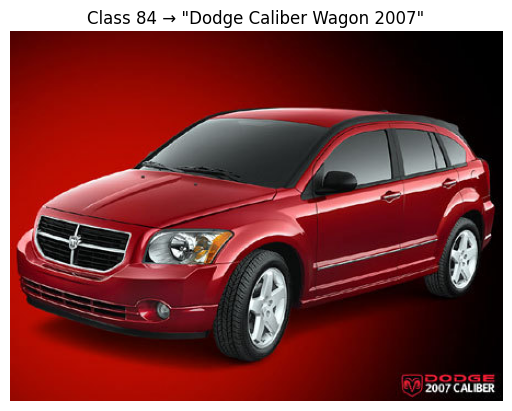

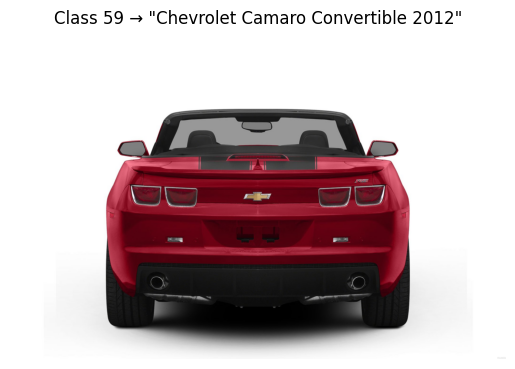

time: 450 ms (started: 2025-03-12 17:51:01 +00:00)


In [ ]:
train_dataset_path = "/content/dataset/cars_train/cars_train"
test_dataset_path = "/content/dataset/cars_test/cars_test"

show_train_image_with_title(example_image_name1, train_dataset_path, df_mapping)

show_test_image_with_title(example_image_name2, test_dataset_path, df_test_mapping)

### Organize images into class folders

In [ ]:
def organize_images(df, dataset_path):
    for index, row in df.iterrows():
        image_name = row["image"]
        class_name = str(row["true_class_name"])

        class_folder = os.path.join(dataset_path, class_name)
        os.makedirs(class_folder, exist_ok=True)

        src_path = os.path.join(dataset_path, image_name)
        dst_path = os.path.join(class_folder, image_name)

        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)

organize_images(df_mapping, train_dataset_path)
organize_images(df_test_mapping, test_dataset_path)

time: 1.68 s (started: 2025-03-05 10:16:23 +00:00)


### Define Image Preprocessing Transformations

---

I define two sets of transformations for the training and testing datasets:

*   Training: Includes resizing, random horizontal flipping, random rotations, and normalization to enhance model robustness.

*   Testing: Resizes and normalizes the images without augmentations to maintain consistency.

These transformations ensure effective learning during training and consistent evaluation during testing.

In [ ]:
def get_transforms():
    """
    Returns the train and test transformations for image preprocessing.
    """
    train_transform = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return train_transform, test_transform

time: 471 µs (started: 2025-03-05 10:16:25 +00:00)


### Prepare DataLoaders for Training, Validation, and Testing

---

This function prepares data loaders for training, validation, and test sets with appropriate transformations and returns them along with the number of classes.

In [ ]:
def prepare_dataloaders(train_dataset_path, test_dataset_path, batch_size=32):
    train_transform, test_transform = get_transforms()

    train_dataset = ImageFolder(root=train_dataset_path, transform=train_transform)
    full_test_dataset = ImageFolder(root=test_dataset_path, transform=test_transform)

    val_size = len(full_test_dataset) // 2
    test_size = len(full_test_dataset) - val_size
    val_dataset, test_dataset = random_split(full_test_dataset, [val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print(f"Train Dataset Size: {len(train_dataset)} images")
    print(f"Validation Dataset Size: {len(val_dataset)} images")
    print(f"Test Dataset Size: {len(test_dataset)} images")
    print(f"Number of Classes: {len(train_dataset.classes)}")

    return train_loader, val_loader, test_loader, len(train_dataset.classes)

time: 742 µs (started: 2025-03-05 10:16:25 +00:00)


### Why I Chose ResNet50 for Transfer Learning?


---


I chose ResNet50 due to its strong performance in image classification tasks and its ability to train deeper networks with residual connections. Its pre-trained Iights provide a solid starting point, making it ideal for transfer learning, allowing us to fine-tune the model effectively for our dataset.

# Base Model


### Model Initialization and Preparation


---


I loaded a pre-trained ResNet50 model with ImageNet Iights and froze its parameters. The final fully connected layer was replaced with one suitable for our dataset's number of classes.

In [ ]:
train_loader, val_loader, test_loader, num_classes = prepare_dataloaders(train_dataset_path, test_dataset_path, batch_size=32)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet50.parameters():
    param.requires_grad = False

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

print("Base Model is ready")

Train Dataset Size: 8144 images
Validation Dataset Size: 4020 images
Test Dataset Size: 4021 images
Number of Classes: 196
Base Model is ready
time: 547 ms (started: 2025-03-04 11:53:36 +00:00)


### Loss Function & Optimizer


* loss function as CrossEntropyLoss for multi-class classification.

* Adam optimizer with a learning rate of 0.001, updating only the final fully connected layer of ResNet50.



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

time: 555 µs (started: 2025-03-04 11:53:37 +00:00)


## Training

### Training loop & Validation

Train ResNet50 for 10 epochs using Transfer Learning. The model updates only the final layer during training and evaluates test accuracy and loss each epoch. Results are printed after every epoch.

In [ ]:
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    resnet50.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%")
    print("-" * 50)

print("Training Complete!")

Epoch [1/10]
Train Loss: 5.3708, Train Acc: 3.24%
Validation Loss: 4.7995, Validation Acc: 5.25%
--------------------------------------------------
Epoch [2/10]
Train Loss: 4.4010, Train Acc: 11.82%
Validation Loss: 4.1575, Validation Acc: 14.75%
--------------------------------------------------
Epoch [3/10]
Train Loss: 3.8037, Train Acc: 20.01%
Validation Loss: 3.8499, Validation Acc: 17.76%
--------------------------------------------------
Epoch [4/10]
Train Loss: 3.4171, Train Acc: 25.86%
Validation Loss: 3.5725, Validation Acc: 19.18%
--------------------------------------------------
Epoch [5/10]
Train Loss: 3.1054, Train Acc: 31.07%
Validation Loss: 3.4209, Validation Acc: 24.65%
--------------------------------------------------
Epoch [6/10]
Train Loss: 2.8759, Train Acc: 35.23%
Validation Loss: 3.2528, Validation Acc: 26.69%
--------------------------------------------------
Epoch [7/10]
Train Loss: 2.6690, Train Acc: 38.73%
Validation Loss: 3.1831, Validation Acc: 28.53%
---

### Loss & Accuracy over epochs

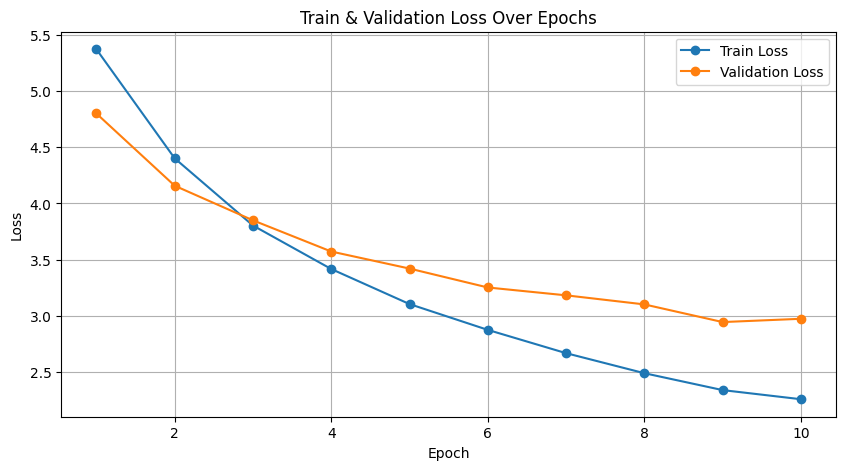

time: 178 ms (started: 2025-03-04 12:16:14 +00:00)


In [ ]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", linestyle="-", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

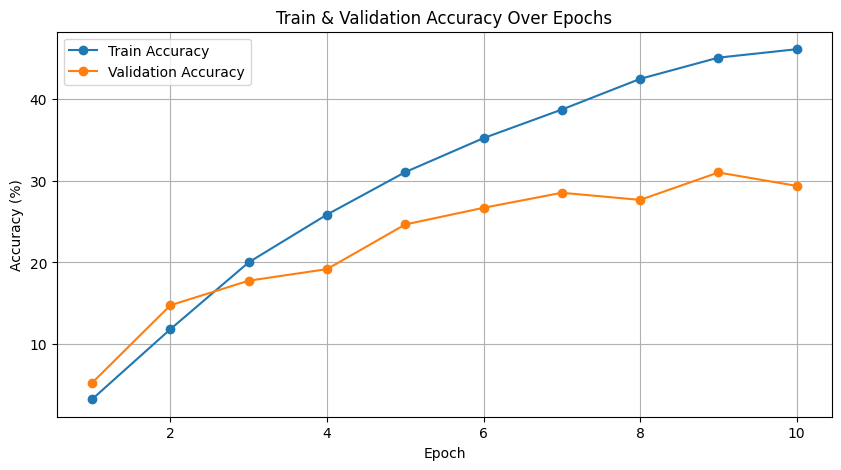

time: 121 ms (started: 2025-03-04 12:16:14 +00:00)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle="-", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", linestyle="-", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Test

In [ ]:
resnet50.eval()
correct_test = 0
total_test = 0
test_loss = 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_names = test_loader.dataset.dataset.classes

report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=1)

print("\nClassification Report for Test Set:\n")
print(report)


Test Loss: 3.0628
Test Accuracy: 28.10%

Classification Report for Test Set:

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     1.0000    0.4000    0.5714        25
                             Acura Integra Type R 2001     0.5714    0.2000    0.2963        20
                                   Acura RL Sedan 2012     0.2308    0.1875    0.2069        16
                                   Acura TL Sedan 2012     0.0000    0.0000    0.0000        16
                                  Acura TL Type-S 2008     0.5714    0.4000    0.4706        20
                                  Acura TSX Sedan 2012     0.3333    0.0455    0.0800        22
                              Acura ZDX Hatchback 2012     0.2857    0.3000    0.2927        20
              Aston Martin V8 Vantage Convertible 2012     0.5000    0.0455    0.0833        22
                    Aston Martin V8 Vantage Coupe 2012   

## Saves checkpoint

In [ ]:
checkpoint_dir = "/content"
checkpoint_filename = "resnet50_base_model.pth"
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

os.makedirs(checkpoint_dir, exist_ok=True)

torch.save({
    'epoch': num_epochs,
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'learning_rate': optimizer.param_groups[0]['lr'],
    'batch_size': train_loader.batch_size
}, checkpoint_path)

print(f"Base Model checkpoint saved at {checkpoint_path}")

Base Model checkpoint saved at /content/resnet50_base_model.pth
time: 156 ms (started: 2025-03-04 12:16:57 +00:00)


## Interim summary #1

---


In the base-model experiment, I observed that the model quickly reached overfitting. While increasing the number of epochs might have improved the results, I realized that to achieve ideal performance, I needed to make more significant changes to the model.

**What did I change?**

This time, instead of training just one layer like in the previous experiment, I fine-tuned the last three layers of the original ResNet50 model. Additionally, I reduced the batch size from 32 to 16. I also introduced a learning rate scheduler (ReduceLROnPlateau), which helps adjust the learning rate based on validation performance, ensuring that the model continues to improve without making large, unstable updates.

# Expirement 1

### Load ResNet50, freeze all layers, and unfreeze only the final 3 layers

In [ ]:
train_loader, val_loader, test_loader, num_classes = prepare_dataloaders(train_dataset_path, test_dataset_path, batch_size=16)

resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in resnet50.parameters():
    param.requires_grad = False

for param in list(resnet50.children())[-3:]:
    for p in param.parameters():
        p.requires_grad = True

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

print("Experiment 1 is ready")

Train Dataset Size: 8144 images
Validation Dataset Size: 4020 images
Test Dataset Size: 4021 images
Number of Classes: 196
Experiment 1 is ready
time: 542 ms (started: 2025-03-04 14:06:56 +00:00)


### Loss Function , Optimizer and Scheduler
---
I chose the **Adam optimizer** with a learning rate of 0.005 for its ability to adapt the learning rate for each parameter, which helps with faster convergence and stability during training. The filter ensures that only the parameters with `requires_grad=True` are updated, keeping the frozen layers of the ResNet50 model unchanged.

For the **learning rate scheduler**, I used **ReduceLROnPlateau**. This scheduler monitors the validation performance and reduces the learning rate by a factor of 0.1 if the validation metric doesn’t improve for 3 consecutive epochs (patience=3). This helps the model to refine its learning and avoid overshooting optimal solutions as training progresses.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1, verbose=True)

time: 1.18 ms (started: 2025-03-04 14:06:56 +00:00)


## Training

### Training loop & Validation

---

Train ResNet50 for 10 epochs using Transfer Learning. The model updates only the 3 final layer during training and evaluates test accuracy and loss each epoch. Results are printed after every epoch.

In [ ]:
num_epochs = 10

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    resnet50.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%")
    print("-" * 50)

    scheduler.step(val_accuracy)

print("Training Complete!")

Epoch [1/10]
Train Loss: 4.5593, Train Acc: 6.37%
Validation Loss: 3.5144, Validation Acc: 18.36%
--------------------------------------------------
Epoch [2/10]
Train Loss: 2.3410, Train Acc: 39.29%
Validation Loss: 1.8302, Validation Acc: 49.15%
--------------------------------------------------
Epoch [3/10]
Train Loss: 1.2092, Train Acc: 65.88%
Validation Loss: 1.1279, Validation Acc: 68.46%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.7194, Train Acc: 79.05%
Validation Loss: 0.9694, Validation Acc: 72.56%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.4676, Train Acc: 86.67%
Validation Loss: 0.7716, Validation Acc: 78.11%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.3187, Train Acc: 90.90%
Validation Loss: 0.6694, Validation Acc: 81.02%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.2627, Train Acc: 92.01%
Validation Loss: 0.7714, Validation Acc: 78.88%
--

### Loss & Accuracy over epochs

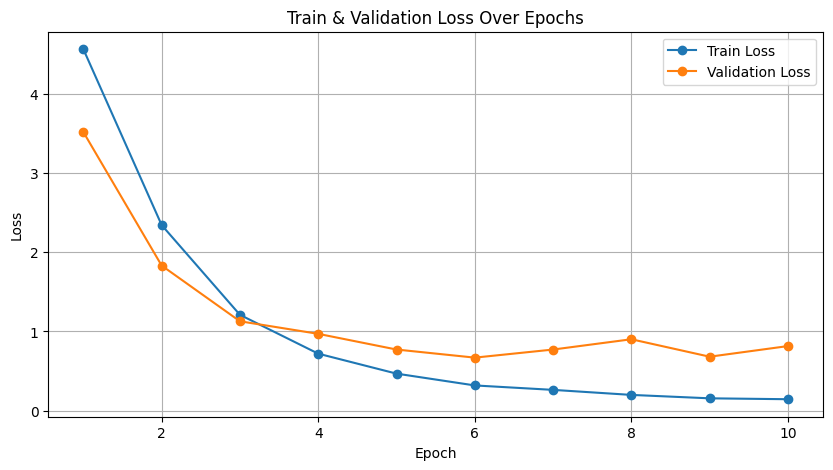

time: 164 ms (started: 2025-03-04 14:33:43 +00:00)


In [ ]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", linestyle="-", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

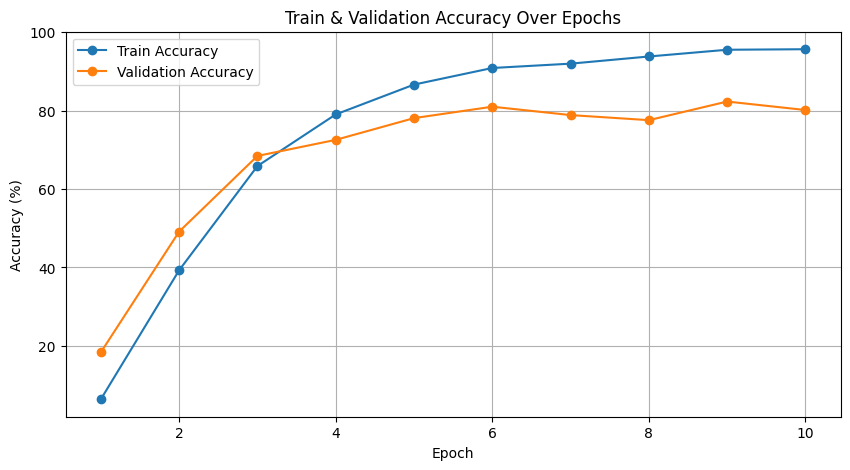

time: 122 ms (started: 2025-03-04 14:33:43 +00:00)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle="-", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", linestyle="-", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Test

In [ ]:
resnet50.eval()
correct_test = 0
total_test = 0
test_loss = 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_names = test_loader.dataset.dataset.classes

report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=1)

print("\nClassification Report for Test Set:\n")
print(report)

Test Loss: 0.7619
Test Accuracy: 79.88%

Classification Report for Test Set:

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.9333    0.6667    0.7778        21
                             Acura Integra Type R 2001     0.5128    0.9091    0.6557        22
                                   Acura RL Sedan 2012     1.0000    0.7333    0.8462        15
                                   Acura TL Sedan 2012     0.8333    0.9524    0.8889        21
                                  Acura TL Type-S 2008     0.9310    0.9643    0.9474        28
                                  Acura TSX Sedan 2012     1.0000    0.6111    0.7586        18
                              Acura ZDX Hatchback 2012     0.9375    0.7500    0.8333        20
              Aston Martin V8 Vantage Convertible 2012     0.7000    0.6087    0.6512        23
                    Aston Martin V8 Vantage Coupe 2012   

## Saves checkpoint

In [ ]:
checkpoint_dir = "/content"
checkpoint_filename = "resnet50_experiment1.pth"
checkpoint_path_exp1 = os.path.join(checkpoint_dir, checkpoint_filename)

os.makedirs(checkpoint_dir, exist_ok=True)

torch.save({
    'epoch': num_epochs,
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'learning_rate': optimizer.param_groups[0]['lr'],
    'batch_size': train_loader.batch_size
}, checkpoint_path_exp1)

print(f"Checkpoint for Experiment 1 saved at {checkpoint_path_exp1}")

Checkpoint for Experiment 1 saved at /content/resnet50_experiment1.pth
time: 498 ms (started: 2025-03-04 14:34:24 +00:00)


## Interim summary #2

---

In Experiment 1, I are very satisfied with the performance of the model, achieving an accuracy of 80.17% on the validation set and 79.89% on the test set. HoIver, it is clear that, in the later epochs, the model's improvement on the validation set stagnates, indicating some overfitting. From epoch 5 onwards, where the model reached 78% accuracy, there Ire minimal improvements, and the model ends the training with a slight increase to 80.17% on validation accuracy. This suggests that although the model shows good overall performance, further improvements on the validation set became harder to achieve, likely due to overfitting.

# Expirement 2

###  ResNet50 & make all layers trainable and prepares it for fine-tuning

---
Unlike in Experiment 1, where I froze most of the layers of the ResNet50 model, in Experiment 2, I unfreezed all layers of the ResNet50 model by setting `param.requires_grad=True` for all parameters. This allows the entire model to fine-tune during training, potentially improving performance. In addition, I reverted to a batch size of 32, as I found from previous runs that with the chosen model, batch size has less impact on the results and doesn’t significantly affect performance.

In [ ]:
train_loader, val_loader, test_loader, num_classes = prepare_dataloaders(train_dataset_path, test_dataset_path, batch_size=32)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet50.parameters():
    param.requires_grad = True

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

print("Experiment 2 is ready")

Train Dataset Size: 8144 images
Validation Dataset Size: 4020 images
Test Dataset Size: 4021 images
Number of Classes: 196


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


Experiment 2 is ready
time: 1.44 s (started: 2025-03-05 10:17:30 +00:00)


### Loss Function , Optimizer and Scheduler

---

I switched to **SGD with momentum** because I fount out that it is a commonly used optimizer for fine-tuning pretrained models. It can help the model converge faster and more smoothly, especially when dealing with complex networks like ResNet50. By adding **momentum**, the optimizer can also help the model avoid getting stuck in local minima, which can happen in deep learning tasks. I chose **learning rate 0.01** to allow the model to learn more quickly while avoiding too slow convergence. Finally, I adjusted the **ReduceLROnPlateau scheduler**'s **threshold to 0.9** to allow the learning rate to decrease if the validation performance stops improving for a while.

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

time: 1.16 ms (started: 2025-03-05 10:17:31 +00:00)


## Training

### Training loop & Validation

---
Train ResNet50 for 10 epochs using Transfer Learning. The model updates the layer during training and evaluates test accuracy and loss each epoch. Results are printed after every epoch.


In [ ]:
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    resnet50.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%")
    print("-" * 50)

print("Experiment 2 Training Complete!")

Epoch [1/10]
Train Loss: 4.0994, Train Acc: 13.99%
Validation Loss: 2.8534, Validation Acc: 28.03%
--------------------------------------------------
Epoch [2/10]
Train Loss: 1.8014, Train Acc: 53.01%
Validation Loss: 1.6507, Validation Acc: 55.30%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.9580, Train Acc: 74.28%
Validation Loss: 1.3915, Validation Acc: 60.25%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.5805, Train Acc: 84.26%
Validation Loss: 0.8586, Validation Acc: 75.65%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.3886, Train Acc: 89.76%
Validation Loss: 0.8929, Validation Acc: 74.48%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.2842, Train Acc: 92.53%
Validation Loss: 0.6155, Validation Acc: 82.71%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.1239, Train Acc: 97.68%
Validation Loss: 0.3099, Validation Acc: 91.14%
-

### Loss & Accuracy over epochs

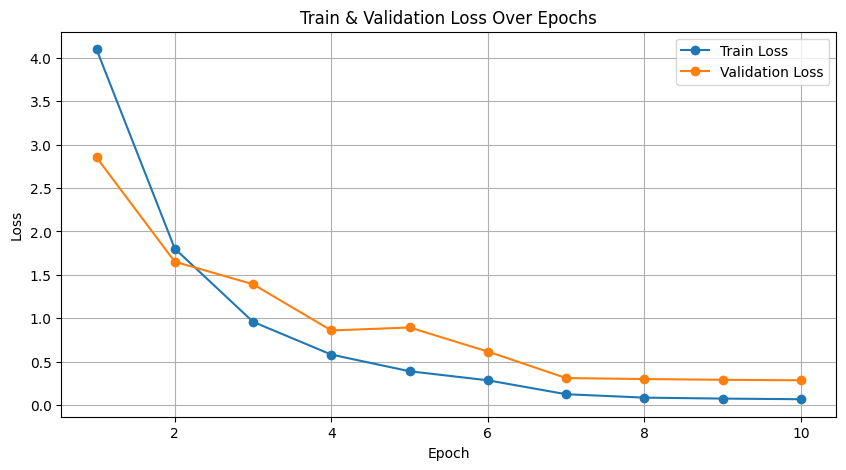

time: 190 ms (started: 2025-03-05 11:06:41 +00:00)


In [ ]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", linestyle="-", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

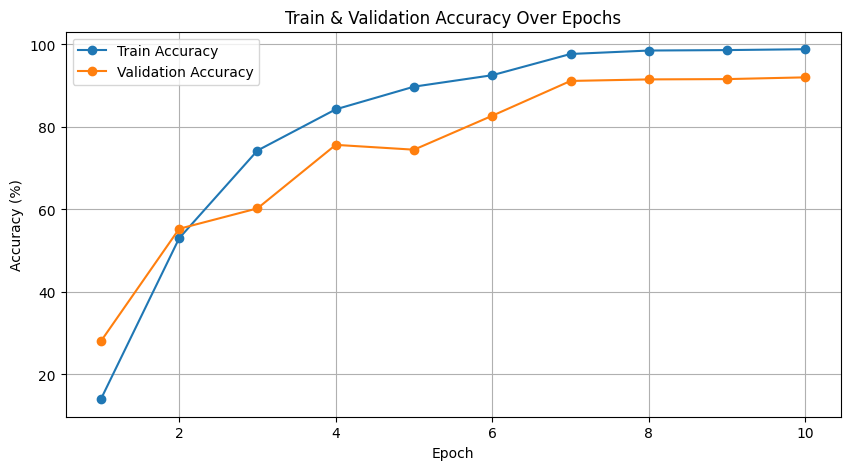

time: 126 ms (started: 2025-03-05 11:06:42 +00:00)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle="-", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", linestyle="-", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Test

In [ ]:
resnet50.eval()
correct_test = 0
total_test = 0
test_loss = 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_names = test_loader.dataset.dataset.classes

report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=1)

print("\nClassification Report for Test Set:\n")
print(report)

Test Loss: 0.2930
Test Accuracy: 92.14%

Classification Report for Test Set:

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.8696    1.0000    0.9302        20
                             Acura Integra Type R 2001     0.8696    1.0000    0.9302        20
                                   Acura RL Sedan 2012     0.8667    0.8667    0.8667        15
                                   Acura TL Sedan 2012     0.8571    1.0000    0.9231        24
                                  Acura TL Type-S 2008     1.0000    0.9545    0.9767        22
                                  Acura TSX Sedan 2012     1.0000    0.7778    0.8750        18
                              Acura ZDX Hatchback 2012     1.0000    0.8824    0.9375        17
              Aston Martin V8 Vantage Convertible 2012     0.7826    0.8571    0.8182        21
                    Aston Martin V8 Vantage Coupe 2012   

## Final Summary

---
In Experiment 2, the model showed strong performance with training accuracy increasing from 13.99% to 98.83% by the final epoch. Validation accuracy also improved significantly, reaching 92.01% by the end of training. The test accuracy, which was 92.14%, closely matched the validation results, indicating good generalization. While the model performed well overall, I observed some overfitting in the later epochs, as the validation accuracy plateaued despite further improvements in training accuracy. However, the model still achieved excellent results across both validation and test sets and this is the model I will have in the Test Environment.

## Saves checkpoint

In [ ]:
checkpoint_dir = "/content"
checkpoint_filename = "resnet50_experiment_2.pth"
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

os.makedirs(checkpoint_dir, exist_ok=True)

torch.save({
    'epoch': num_epochs,
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'learning_rate': optimizer.param_groups[0]['lr'],
    'batch_size': train_loader.batch_size
}, checkpoint_path)

print(f"Checkpoint for Experiment 2 saved at {checkpoint_path}")

Checkpoint for Experiment 2 saved at /content/resnet50_experiment_2.pth
time: 305 ms (started: 2025-03-05 11:07:22 +00:00)


# Save the best model

In [ ]:
##%%script echo Skipping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 37.5 s (started: 2025-03-05 11:09:22 +00:00)


In [ ]:
drive_checkpoint_dir = "/content/drive/MyDrive/"
drive_checkpoint_path = os.path.join(drive_checkpoint_dir, checkpoint_filename)

!cp {checkpoint_path} {drive_checkpoint_path}

print(f"Checkpoint saved in Google Drive at {drive_checkpoint_path}")

Checkpoint saved in Google Drive at /content/drive/MyDrive/resnet50_experiment_2.pth
time: 505 ms (started: 2025-03-05 11:10:37 +00:00)


# Test Environment

To test the best model, simply run all the cells in the Test Environment and upload the car images you want classified.

Imports

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import torchvision.models as models
import pandas as pd
import gdown

time: 9.93 s (started: 2025-03-12 19:14:12 +00:00)


Download class mapping file & load class mapping

In [ ]:
file_id = "here_add_file_id"
xls_path = "here_add_path"
gdown.download(f"https://drive.google.com/uc?id={file_id}", xls_path, quiet=False)

df_test_mapping = pd.read_excel(xls_path, sheet_name="test")
df_test_mapping["image"] = df_test_mapping["image"].astype(str).str.replace("'", "").str.strip()

Loading the best-trained ResNet-50 model and prepare for inference

In [ ]:
model_file_id = "here_add_file_id_of_model"
checkpoint_path = "here_add_path_of_model"

gdown.download(f"https://drive.google.com/uc?id={model_file_id}", checkpoint_path, quiet=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

resnet50 = models.resnet50(weights=None)
num_ftrs = resnet50.fc.in_features
num_classes = len(df_test_mapping["class"].unique())
resnet50.fc = torch.nn.Linear(num_ftrs, num_classes)

if "model_state_dict" in checkpoint:
    resnet50.load_state_dict(checkpoint["model_state_dict"])
else:
    resnet50.load_state_dict(checkpoint)

resnet50.to(device)
resnet50.eval()

print("Model successfully loaded from Google Drive!")


Image Preprocessing for Inference


In [ ]:
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

time: 584 µs (started: 2025-03-12 19:14:40 +00:00)


Car Image Classification Prediction Function

In [ ]:
def predict_car(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = resnet50(image_tensor)
        _, predicted = torch.max(output, 1)

    unique_classes = sorted(df_test_mapping["true_class_name"].unique())
    idx_to_class = {idx: class_name for idx, class_name in enumerate(unique_classes)}

    predicted_class_name = idx_to_class.get(predicted.item(), "Unknown")

    correct_class_number = df_test_mapping[df_test_mapping["true_class_name"] == predicted_class_name]["class"].values[0]

    display(image)
    print(f"Predicted: {predicted_class_name} (Class Number: {correct_class_number})")

time: 655 µs (started: 2025-03-12 19:14:42 +00:00)


File Upload Handling and Prediction Execution

In [ ]:
def on_file_upload(change):
    uploaded_files = list(change['new'].keys())

    print("Uploaded files:")
    for file_name in uploaded_files:
        print(f"- {file_name}")

    print("Processing predictions...")

    for file_name in uploaded_files:
        with open(file_name, 'wb') as f:
            f.write(change['new'][file_name]['content'])

        predict_car(file_name)

time: 510 µs (started: 2025-03-12 19:14:44 +00:00)


File Upload Widget for Image Prediction

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Please upload one or more car images:
time: 4.32 ms (started: 2025-03-12 19:14:46 +00:00)
Uploaded files:
- test1.jpeg
- test2.jpeg
- test3.jpeg
- test4.jpeg
- test5.jpeg
- test6.jpeg
- test7.jpeg
- test8.jpeg
- test9.jpeg
- test10.jpeg
- test12.jpeg
- test19.jpeg
- test58.jpeg
- test75.jpeg
- test105.jpeg
- test126.jpeg
Processing predictions...


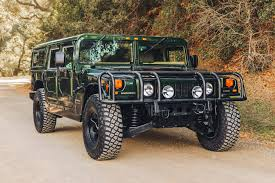

Predicted: AM General Hummer SUV 2000 (Class Number: 1)


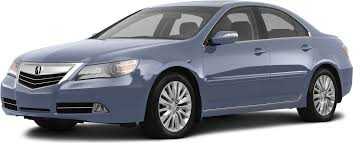

Predicted: Acura RL Sedan 2012 (Class Number: 2)


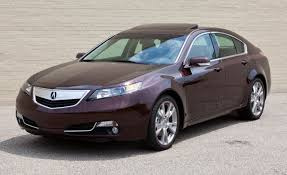

Predicted: Acura TL Sedan 2012 (Class Number: 3)


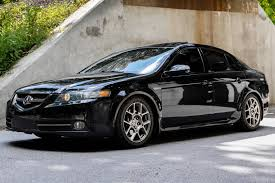

Predicted: Acura TL Type-S 2008 (Class Number: 4)


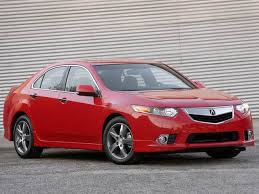

Predicted: Acura TSX Sedan 2012 (Class Number: 5)


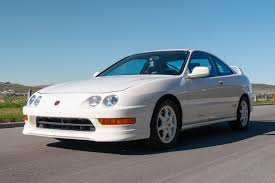

Predicted: Acura Integra Type R 2001 (Class Number: 6)


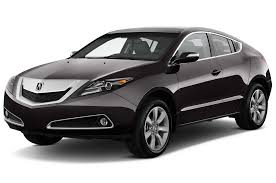

Predicted: Acura ZDX Hatchback 2012 (Class Number: 7)


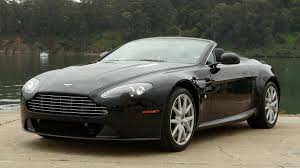

Predicted: Aston Martin V8 Vantage Convertible 2012 (Class Number: 8)


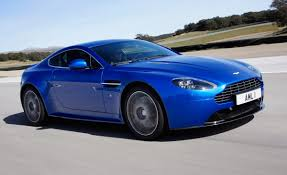

Predicted: Aston Martin V8 Vantage Coupe 2012 (Class Number: 9)


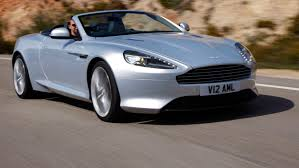

Predicted: Aston Martin V8 Vantage Convertible 2012 (Class Number: 8)


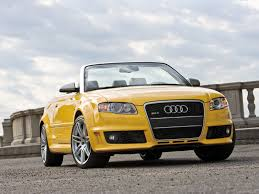

Predicted: Audi RS 4 Convertible 2008 (Class Number: 12)


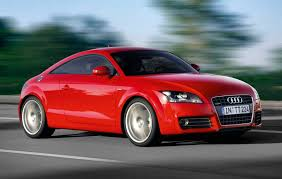

Predicted: Audi TT Hatchback 2011 (Class Number: 19)


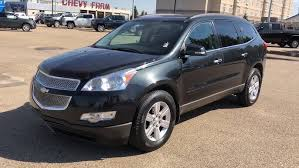

Predicted: Chevrolet Traverse SUV 2012 (Class Number: 58)


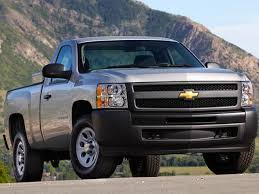

Predicted: Chevrolet Silverado 2500HD Regular Cab 2012 (Class Number: 69)


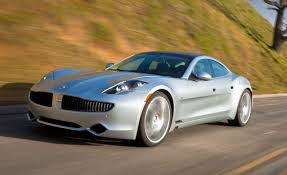

Predicted: Fisker Karma Sedan 2012 (Class Number: 105)


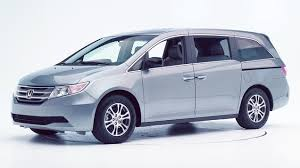

Predicted: Honda Odyssey Minivan 2012 (Class Number: 126)


In [ ]:
upload_widget = widgets.FileUpload(accept="image/*", multiple=True)
upload_widget.observe(on_file_upload, names='value')

display(upload_widget)
print("Please upload one or more car images:")